In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

F:\ProgramData\Anaconda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
F:\ProgramData\Anaconda\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
F:\ProgramData\Anaconda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:\n%s" %


In [2]:
import bq_helper
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import set_matplotlib_formats
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

set_matplotlib_formats('retina')
%matplotlib inline

from google.cloud import bigquery
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


In [3]:
query = '''
    SELECT 
        FORMAT("%'d",COUNT(DISTINCT fullVisitorId)) AS users,
        FORMAT("%'d",SUM(totals.visits)) AS visits,
        FORMAT("%'d",SUM(totals.pageviews)) AS pageviews,
        FORMAT("%'d", SUM(totals.transactions)) AS transactions,
        SUM(totals.transactionRevenue)/1000000 AS revenue

    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
        AND totals.totalTransactionRevenue IS NOT NULL
'''

safe_query_job = client.query(query)
high_level_aug = safe_query_job.to_dataframe()

high_level_aug.head()

,users,visits,pageviews,transactions,revenue
0,"2,868","3,176","92,822","3,314",386199.7


#### Inference : 

During 2016Q4, the Google merchendise store had over 3000 visits, almost 93,000 pageviews and earned $ 386,200 in revenue.

In [4]:
query = """    
    SELECT 
        DATE_TRUNC(PARSE_DATE('%Y%m%d',date), MONTH) AS month,
        SUM(totals.visits) AS visits,        
        SUM(totals.transactionRevenue)/1000000 AS revenue

    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
        AND totals.totalTransactionRevenue IS NOT NULL
    GROUP BY 1
    ORDER BY 1
        
"""
safe_query_job = client.query(query)
df1 = safe_query_job.to_dataframe()
df1.head()

,month,visits,revenue
0,2016-10-01,872,113329.07
1,2016-11-01,919,119013.87
2,2016-12-01,1385,153856.76


### Inference:

December generated over $ 153,000 in revenue and garned almost 1400 visits to the Google Merchandise store. The revenue generated in Dec accounted for 40% of Q4 sales, indicating a holiday surge that is typically seen in retail. 

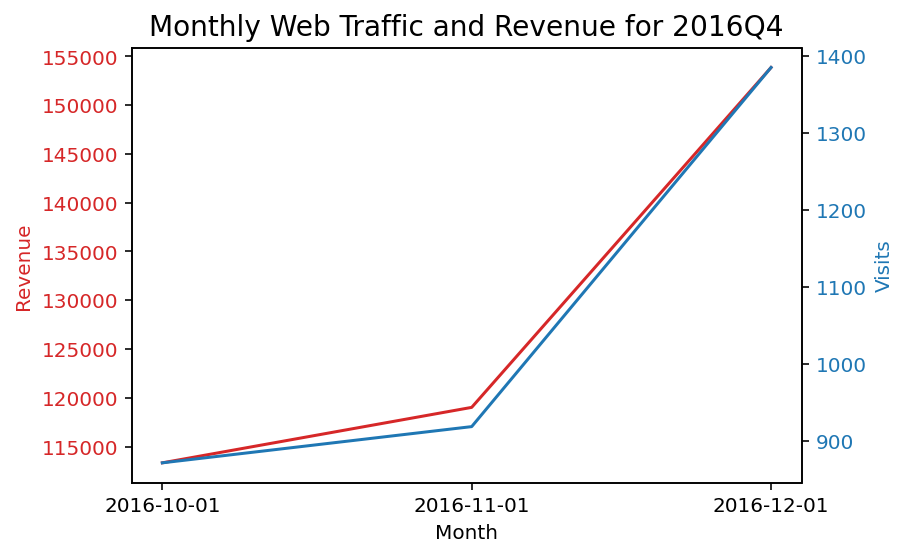

In [5]:
fig,ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Revenue', color=color)
ax1.plot(df1['month'], df1['revenue'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Visits', color=color)  # we already handled the x-label with ax1
ax2.plot(df1['month'], df1['visits'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Monthly Web Traffic and Revenue for 2016Q4', fontsize=14)
plt.xticks(df1['month'],rotation=45)
plt.show()

In [6]:
# create table with revenue by country
# traffic by month
query = """
    SELECT 
        geoNetwork.country AS country,   
        SUM(totals.transactionRevenue)/1000000 AS revenue

    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
        AND totals.totalTransactionRevenue IS NOT NULL
    GROUP BY 1
    ORDER BY 2 desc
    
"""
safe_query_job = client.query(query)
df2 = safe_query_job.to_dataframe()
df2.head()


,country,revenue
0,United States,365518.96
1,Canada,9975.27
2,Kenya,3679.30
3,Puerto Rico,656.16
4,United Kingdom,527.10


In [7]:
# create a heatmap of revenue by geo location

fig = go.Figure(data=go.Choropleth(
    locations=df2['country'], 
    z = df2['revenue'].astype(float),
    locationmode = 'country names', 
    colorscale = 'Reds',
    colorbar_title = "revenue USD",
))

fig.update_layout(
    title_text = '2016Q4 Google Merchandise Store by Geo Location',)
fig.show()

## Top channels sending traffic to GM

In [8]:
# create a table of metrics by channel

query = """
    SELECT
        channelGrouping as channel,
        SUM(totals.totalTransactionRevenue)/1000000 AS revenue,
        SUM(totals.transactions) AS transactions,
        COUNT(DISTINCT fullVisitorId) AS users,
        SUM(totals.visits) AS sessions,
        SUM(totals.pageviews) AS pageviews
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
        AND totals.totalTransactionRevenue IS NOT NULL
    GROUP BY
        1
    ORDER BY
        2 DESC
"""
safe_query_job = client.query(query)
df3 = safe_query_job.to_dataframe()
df3.head()


,channel,revenue,transactions,users,sessions,pageviews
0,Referral,182578.60,1540,1331,1470,42829
1,Direct,128141.06,568,456,539,16132
2,Organic Search,93376.88,991,905,956,28247
3,Paid Search,14028.37,164,153,160,4277
4,Display,4728.45,34,34,34,1044


Text(0.5, 1.0, 'Total Pageviews by Channel')

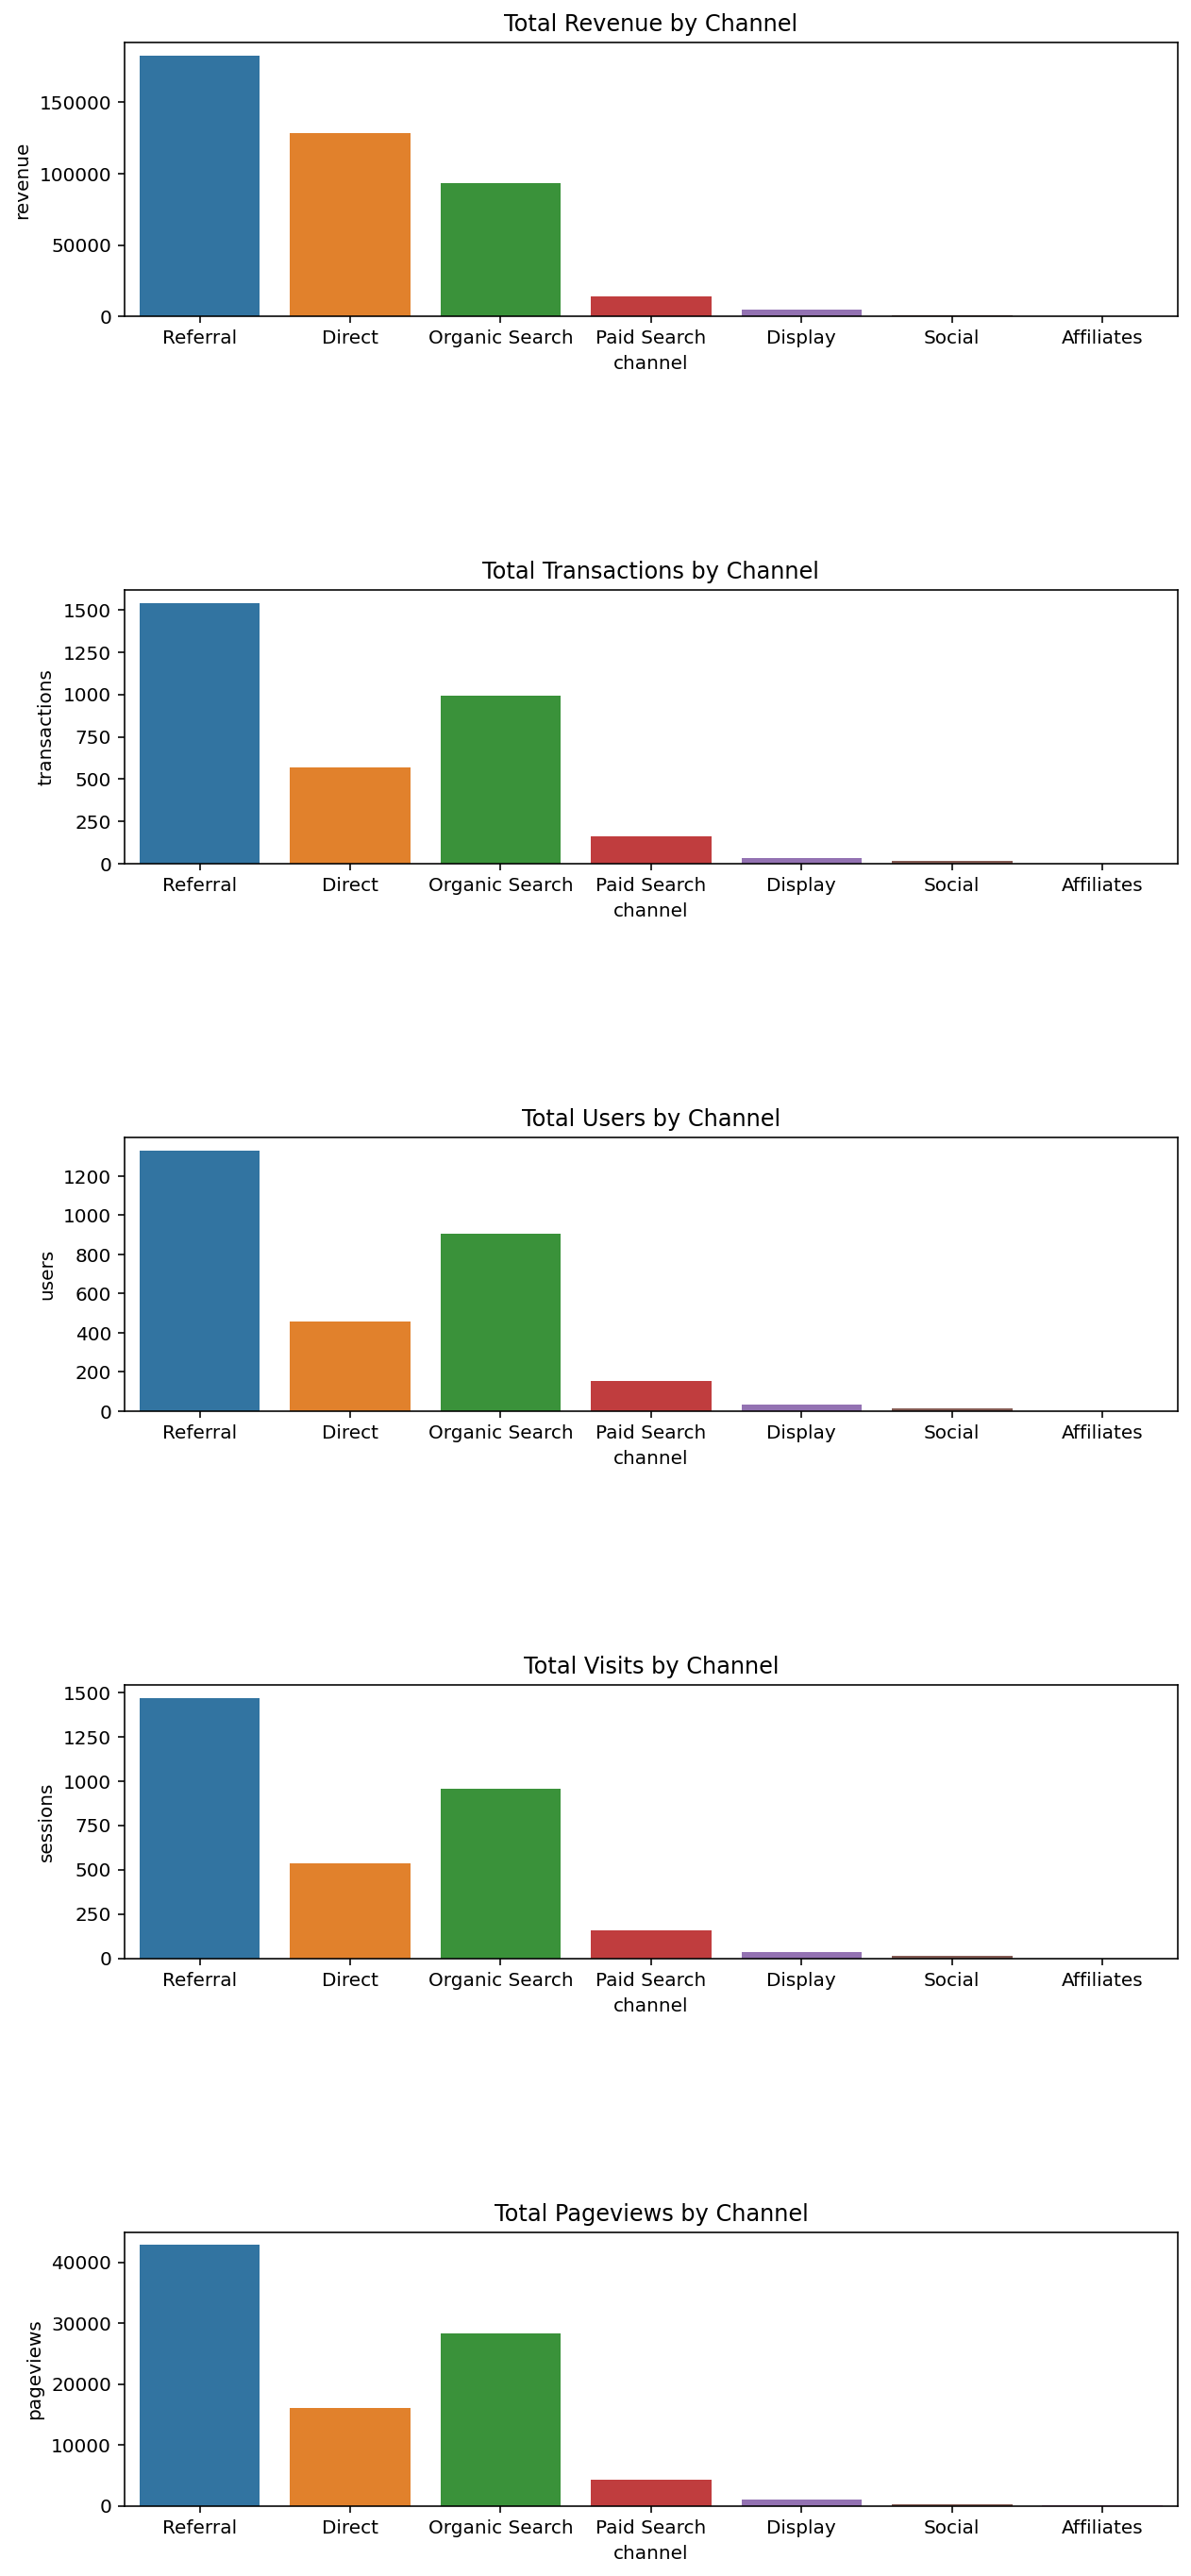

In [9]:
# set up the matplotlib figure
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(10,24))
fig.subplots_adjust(hspace=1)

sns.barplot(x='channel',y='revenue',data=df3,estimator=sum,ax=ax1)

sns.barplot(x='channel',y='transactions',data=df3,estimator=sum,ax=ax2)

sns.barplot(x='channel',y='users',data=df3,estimator=sum,ax=ax3)

sns.barplot(x='channel',y='sessions',data=df3,estimator=sum,ax=ax4)

sns.barplot(x='channel',y='pageviews',data=df3,estimator=sum,ax=ax5)

ax1.set_title('Total Revenue by Channel')
ax2.set_title('Total Transactions by Channel')
ax3.set_title('Total Users by Channel')
ax4.set_title('Total Visits by Channel')
ax5.set_title('Total Pageviews by Channel')

### User Behavior On Google Merchandise

In [10]:
query = """
    SELECT 
        fullVisitorId AS userID,
        AVG(totals.timeOnSite) As avgTimeOnSite,
        SUM(totals.pageviews) AS pageviews,
        SUM(totals.transactions) AS transactions
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
    GROUP BY
        1
    ORDER BY 1
        
"""
safe_query_job = client.query(query)
df4 = safe_query_job.to_dataframe()

df4['transactions'].fillna(0, inplace=True)
df4.head()

,userID,avgTimeOnSite,pageviews,transactions
0,0000010278554503158,194.0,8.0,0.0
1,0000020424342248747,297.0,13.0,0.0
2,0000152474579038632,162.0,2.0,0.0
3,0000174067426171406,559.5,30.0,0.0
4,000033471059618621,NaN,1.0,0.0


In [11]:
pearson_corr = df4.corr(method='pearson')
pearson_corr

,avgTimeOnSite,pageviews,transactions
avgTimeOnSite,1.000000,0.454428,0.242365
pageviews,0.454428,1.000000,0.525083
transactions,0.242365,0.525083,1.000000


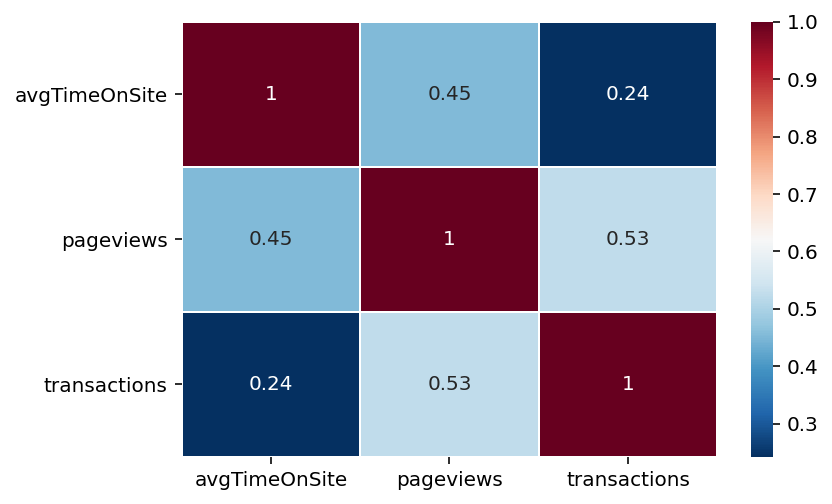

In [12]:
sns.heatmap(pearson_corr,xticklabels=pearson_corr.columns,
              yticklabels=pearson_corr.columns,cmap='RdBu_r',
              annot=True,linewidth=0.5)

### Most visited pages on site ?

In [13]:
query = """
    SELECT
        hits.page.pagePathLevel1 AS pagePath,
        SUM(totals.pageviews) AS pageviews
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
      UNNEST(hits) AS hits
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 10
"""
safe_query_job = client.query(query)
df5 = safe_query_job.to_dataframe()
df5


,pagePath,pageviews
0,/google+redesign/,13059899
1,/home,2320076
2,/basket.html,2251571
3,/store.html,693064
4,/signin.html,373752
5,/asearch.html,342792
6,/yourinfo.html,309919
7,/payment.html,305266
8,/ordercompleted.html,214672
9,/revieworder.html,144310


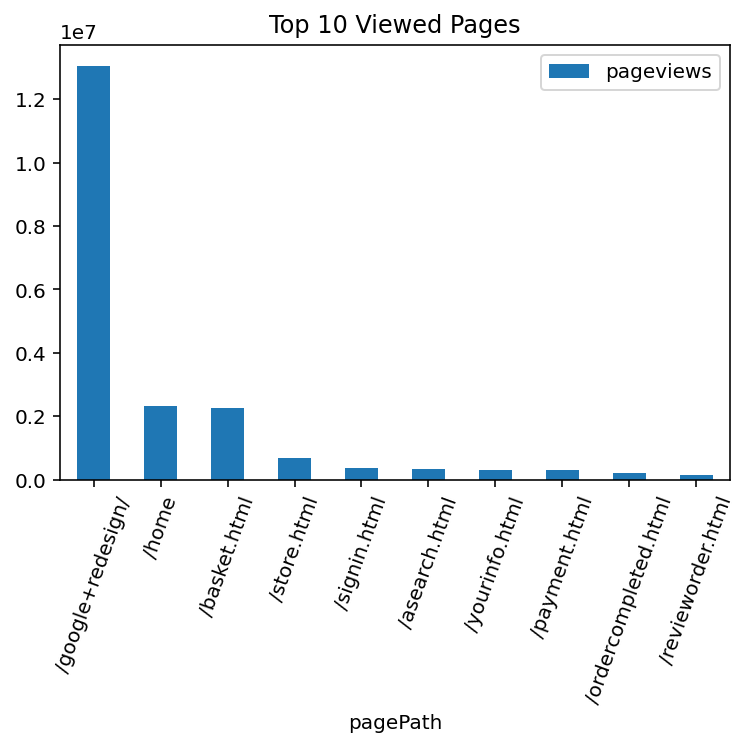

In [14]:
df5.plot.bar(x='pagePath', y='pageviews', rot=70, title='Top 10 Viewed Pages')
plt.show()

In [15]:
query = """
    SELECT
        product.v2ProductCategory AS product_category,
        product.v2ProductName AS product_name,
        product.productSKU AS product_sku,
        product.productPrice/1e6 AS product_price,
        product.productQuantity AS product_quantity,
        product.productRevenue/1e6 AS product_revenue,
        totals.totalTransactionRevenue/1e6 AS total_revenue
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
      UNNEST(hits) AS hits,
      UNNEST(hits.product) AS product
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
        AND productRevenue IS NOT NULL
"""
safe_query_job = client.query(query)
df6 = safe_query_job.to_dataframe()
df6.head()

,product_category,product_name,product_sku,product_price,product_quantity,product_revenue,total_revenue
0,Apparel,Google Vintage Henley Grey/Black,GGOEGAEJ035314,23.99,1,27.99,27.99
1,Electronics,Google G Noise-reducing Bluetooth Headphones,GGOEGEVB070599,119.99,1,122.99,122.99
2,Apparel,Google Men's Long Sleeve Raglan Ocean Blue,GGOEGAEC033113,19.99,2,42.98,42.98
3,Drinkware,Engraved Ceramic Google Mug,GGOEGDWC020199,7.19,1,11.69,26.58
4,Drinkware,Red Shine 15 oz Mug,GGOEGDWR015799,10.39,1,14.89,26.58


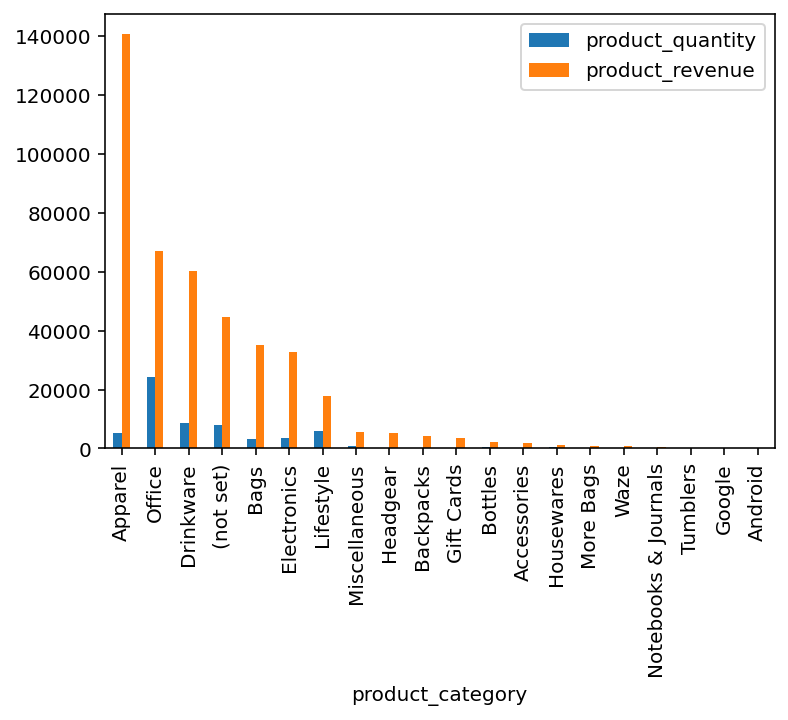

In [16]:
df6['product_category'].unique()
df6 = df6.replace(['${productitem.product.origCatName}'], 'Miscellaneous')

pivot = pd.pivot_table(df6, index=['product_category'], values=['product_revenue', 'product_quantity'], aggfunc=np.sum).sort_values(by='product_revenue', ascending=False)
pivot.plot(kind='bar')

### Shopping Cart Abandonment

In [17]:
query = """
    SELECT
        hits.eCommerceAction.action_type AS actions,
        COUNT(fullVisitorId) AS total_hits
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
      UNNEST(hits) AS hits,
      UNNEST(hits.product) AS product
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
    AND
        (hits.ecommerceaction.action_type != '0' AND hits.ecommerceaction.action_type != '4' AND hits.ecommerceaction.action_type != '3')
    GROUP BY 
        1
    ORDER BY 1
"""
safe_query_job = client.query(query)
df7 = safe_query_job.to_dataframe()
df7.head()

,actions,total_hits
0,1,111457
1,2,92030
2,5,60395
3,6,19802


In [18]:
df7['actions'] = df7['actions'].astype(str)
df7['actions'] = df7['actions'].replace(['0','1','2','3','4','5','6'],['Unknown','Click through of product lists','Product detail views','Add product(s) to cart','Remove products from cart',
                                'Check out','Completed purchase'])

In [19]:
fig = go.Figure(go.Funnel(y = df7['actions'],x = df7['total_hits'],textposition = 'inside',textinfo = 'value+percent initial'))
fig.update_layout(title_text = 'Shopping Cart Abandonment')
fig.show()

### Visits per Continent

In [20]:
query = """
    SELECT geoNetwork AS place
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
"""

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
q_job = client.query(query, job_config=safe_config)

df8 = q_job.to_dataframe()

continent_lst = []
for x in df8['place']:
    x = x['continent']
    continent_lst.append(x)
df8['continents'] = continent_lst

continent_count = {'Americas': 0, 'Asia': 0, 'Europe': 0, 'Oceania': 0, 'Africa': 0}
for continent in df8['continents']:
    if continent == 'Americas':
        continent_count['Americas'] += 1
    if continent == 'Asia':
        continent_count['Asia'] += 1
    if continent == 'Europe':
        continent_count['Europe'] += 1
    if continent == 'Oceania':
        continent_count['Oceania'] += 1
    if continent == 'Africa':
        continent_count['Africa'] += 1


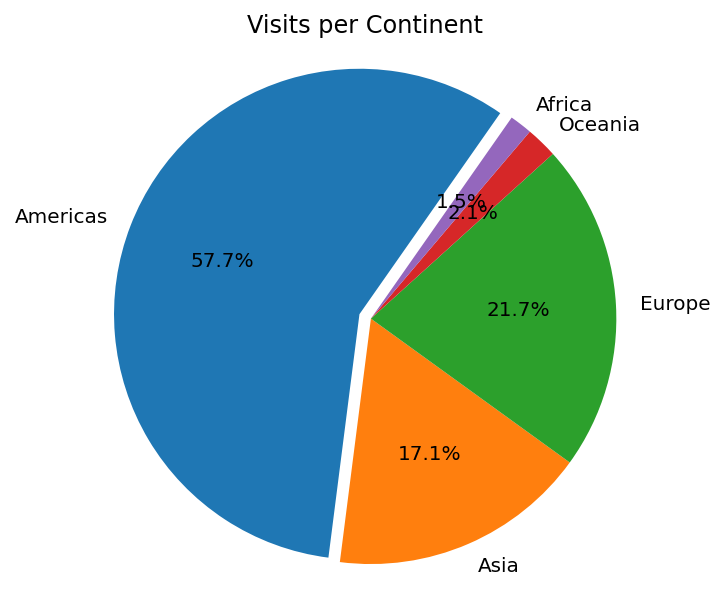

In [21]:
labels = continent_count.keys()
data = continent_count.values()
explode = (0.05, 0, 0,0,0)

plt.figure(figsize=(5,5))
plt.pie(data, labels=labels, explode=explode, autopct='%1.1f%%', startangle=55)
plt.title('Visits per Continent')
plt.axis('equal') 

plt.show()

In [22]:
query = """
     SELECT trafficSource.source AS source, COUNT(trafficSource) as counts
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
     GROUP BY source
     HAVING counts >= 10
     ORDER BY counts DESC
"""

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

df8 = query_job.to_dataframe()

print(df8)

                 source  counts
0              (direct)    2166
1           youtube.com     180
2  analytics.google.com      57
3              Partners      52
4                   dfa      15
5            google.com      12


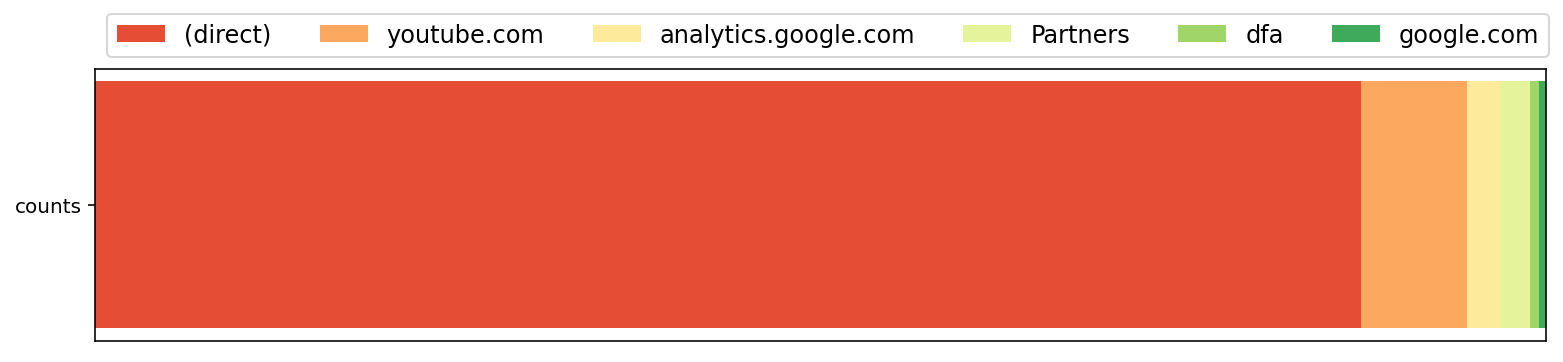

In [23]:
category_names = df8['source']
results = {'counts': df8['counts']}

def survey(results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(13, 2.5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='large')

    return fig, ax


survey(results, category_names)
plt.show()

In [24]:
from time import time

def show_amount_of_data_scanned(query):
    dry_run_config = bigquery.QueryJobConfig(dry_run=True)
    query_job = client.query(query, job_config=dry_run_config)
    print('Data processed: {} GB'.format(round(query_job.total_bytes_processed / 10**9, 3)))
    
def show_time_to_run(query):
    time_config = bigquery.QueryJobConfig(use_query_cache=False)
    start = time()
    query_result = client.query(query, job_config=time_config).result()
    end = time()
    print('Time to run: {} seconds'.format(round(end-start, 3)))


In [25]:
query = """
     SELECT date, august.device.deviceCategory AS device, SUM(august.totals.visits) AS visits
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801` AS august
     GROUP BY date, device
     UNION ALL
     SELECT date, july.device.deviceCategory as device, SUM(july.totals.visits) as visits
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170701` as july
     GROUP BY date, device
     UNION ALL
     SELECT date, june.device.deviceCategory as device, SUM(june.totals.visits) as visits
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170601` as june
     GROUP BY date, device
     UNION ALL
     SELECT date, may.device.deviceCategory as device, SUM(may.totals.visits) as visits
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170501` as may
     GROUP BY date, device
     UNION ALL
     SELECT date, april.device.deviceCategory as device, SUM(april.totals.visits) as visits
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170401` as april
     GROUP BY date, device
     ORDER BY date, device
     """

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

df9 = query_job.to_dataframe()

print(df9)

show_amount_of_data_scanned(query)
show_time_to_run(query)


        date   device  visits
0   20170401  desktop    1420
1   20170401   mobile     646
2   20170401   tablet     104
3   20170501  desktop    1706
4   20170501   mobile     770
5   20170501   tablet     112
6   20170601  desktop    1972
7   20170601   mobile     758
8   20170601   tablet      96
9   20170701  desktop     869
10  20170701   mobile    1036
11  20170701   tablet     143
12  20170801  desktop    1742
13  20170801   mobile     725
14  20170801   tablet      89
Data processed: 0.0 GB
Time to run: 1.51 seconds


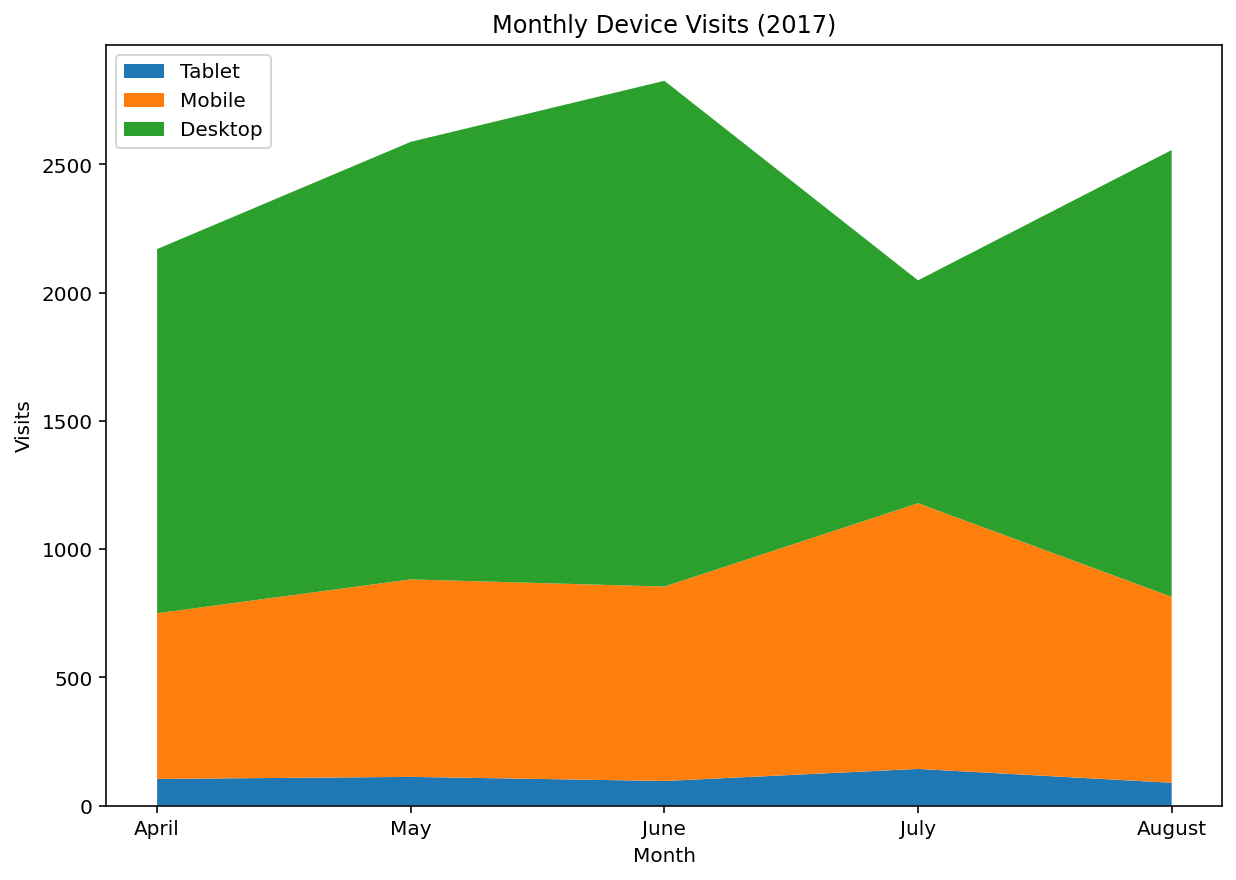

In [26]:
desktop = df9['visits'][0::3]
mobile = df9['visits'][1::3]
tablet = df9['visits'][2::3]

x = ['April', 'May', 'June', 'July', 'August']

y = np.vstack([tablet, mobile, desktop])

labels = ['Tablet', 'Mobile', 'Desktop']

plt.figure(figsize=(10,7))
plt.stackplot(x, tablet, mobile, desktop, labels=labels)
plt.title('Monthly Device Visits (2017)')
plt.ylabel('Visits')
plt.xlabel('Month')
plt.legend(loc='upper left')
plt.show()